In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [ ]:
# Load Tokenizers
with open("user_config.json", "r") as f:
    config = json.load(f)

token_1 = config["huggingface_token"]['token_1'] # from the main acoount
token_2 = config["huggingface_token"]['token_2'] # from the sub account

tokenizer_configs = {
    "google/gemma-2-2b-it": token_1,
    "google/gemma-2-9b-it": token_1,
    "meta-llama/Llama-3.2-1B-Instruct": token_2,
    "meta-llama/Llama-3.2-3B-Instruct": token_2,
    "meta-llama/Llama-3.1-8B-Instruct": token_2,
    "microsoft/phi-4": None,
    "microsoft/Phi-4-mini-instruct": None,
    "microsoft/Phi-3-small-8k-instruct": None,
    "microsoft/Phi-3-mini-4k-instruct": None,
    "microsoft/Phi-3.5-mini-instruct": None,
    "bigscience/bloom-7b1": None,
}

In [ ]:
# Load Testsets
seed = 2025
n_sample = 100

languages = {"eng_Latn": "English", "kor_Hang": "Korean", "deu_Latn": "German"}
samples = {}

for lang_code, lang_name in languages.items():
    dataset = load_dataset("facebook/flores", lang_code, trust_remote_code=True)
    samples[lang_name] = dataset["dev"].shuffle(seed=seed).select(range(n_sample))["sentence"]
    
df = pd.DataFrame()
for lang_name, sample_data in samples.items():
    df[lang_name] = [s for s in sample_data]


In [60]:
for tokenizer_name, token in tokenizer_configs.items():
    try:
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True, token=token, trust_remote_code=True)
        print(f"Loaded {tokenizer_name}")
        for lang_name in languages.values():
            df[f"{tokenizer_name}_{lang_name}_tokens"] = df[lang_name].apply(lambda x: tokenizer.tokenize(x))
            # df[f"{tokenizer_name}_{lang_name}_token_length"] = df[f"{tokenizer_name}_{lang_name}_tokens"].apply(len)
    except Exception as e:
        print(f"Failed to load tokenizer {tokenizer_name}: {e}")

Loaded google/gemma-2-2b-it
Loaded google/gemma-2-9b-it
Loaded meta-llama/Llama-3.2-1B-Instruct
Loaded meta-llama/Llama-3.2-3B-Instruct
Loaded meta-llama/Llama-3.1-8B-Instruct
Loaded microsoft/phi-4
Loaded microsoft/Phi-4-mini-instruct
Loaded microsoft/Phi-3-small-8k-instruct
Loaded microsoft/Phi-3-mini-4k-instruct
Loaded microsoft/Phi-3.5-mini-instruct
Loaded bigscience/bloom-7b1


In [63]:
df.to_csv("toknizers_comparison.csv", index=False)

/tmp/ipykernel_2908824/2130911075.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="Tokenizer", y="Avg Token Length", palette="viridis")


Saved: output/image/token_length_English.png


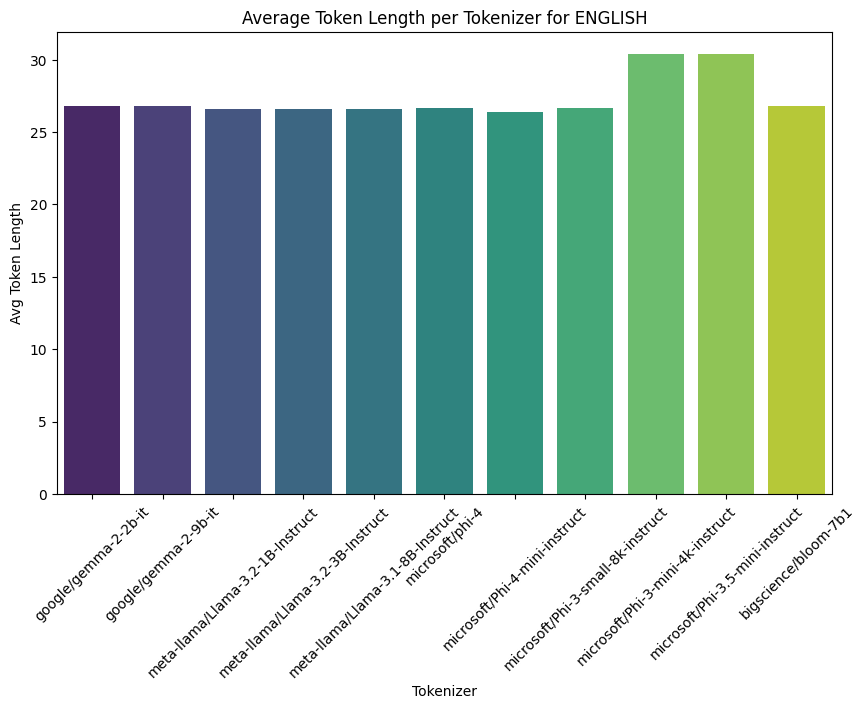

/tmp/ipykernel_2908824/2130911075.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="Tokenizer", y="Avg Token Length", palette="viridis")


Saved: output/image/token_length_Korean.png


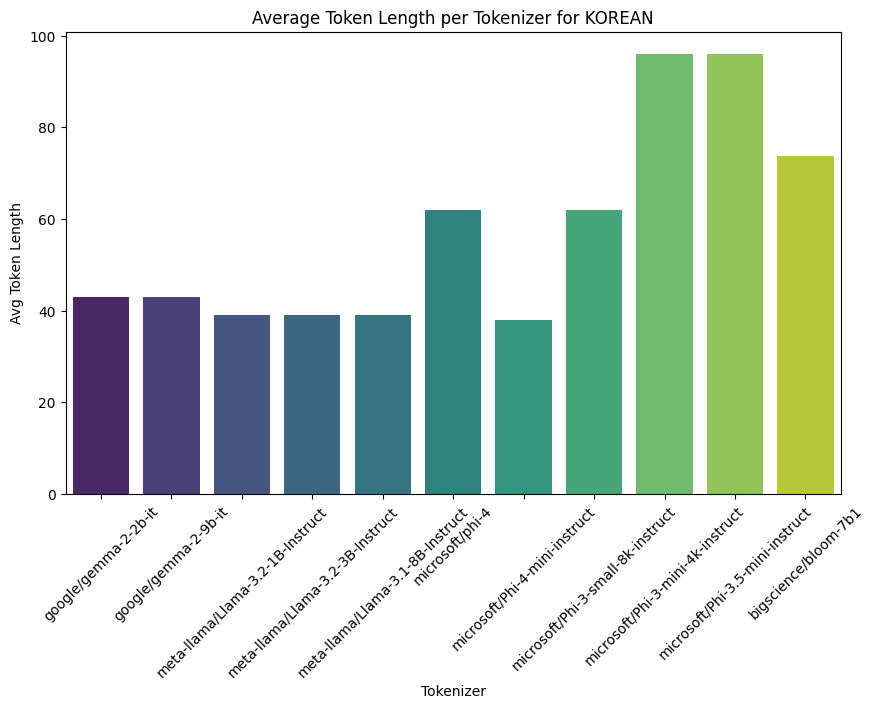

/tmp/ipykernel_2908824/2130911075.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="Tokenizer", y="Avg Token Length", palette="viridis")


Saved: output/image/token_length_German.png


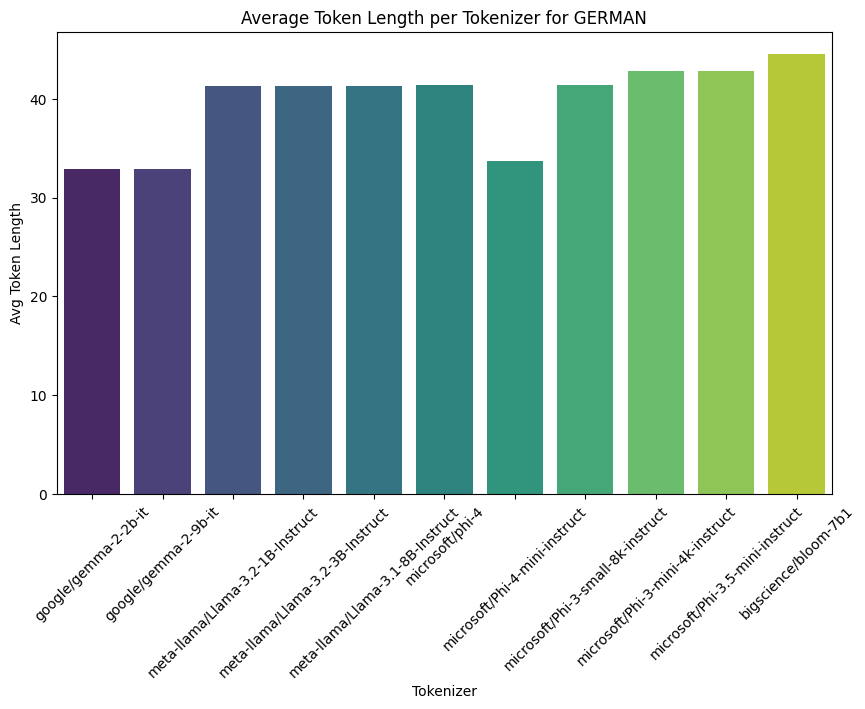

In [ ]:
# Create a plot for each language
for lang in languages.values():
    plt.figure(figsize=(10, 6))

    # Extract average token lengths for each tokenizer in the given language
    avg_lengths = {
        tokenizer_name: df[f"{tokenizer_name}_{lang}_tokens"].apply(len).mean()
        for tokenizer_name in tokenizer_configs.keys()
    }

    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(list(avg_lengths.items()), columns=["Tokenizer", "Avg Token Length"])

    # Plot
    sns.barplot(data=plot_df, x="Tokenizer", y="Avg Token Length", palette="viridis")
    plt.title(f"Average Token Length per Tokenizer for {lang.upper()}")
    plt.ylabel("Avg Token Length")
    plt.xlabel("Tokenizer")
    plt.xticks(rotation=45)
    
    save_path = os.path.join("output/image", f"token_length_{lang}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # Save with high resolution
    print(f"Saved: {save_path}")

    # Show the plot
    plt.show()